In [69]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)
import functions.plotting as NNplt
from functions.rnn_cryptic import generate_sequences, convert_seq2inputs,\
                                  pad_seqs_2step, pad_seqs_1step, calculate_output, onehot2seq 

from sklearn.metrics import r2_score
import math

In [62]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        y = 1/math.sqrt(hidden_size)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.001)

def run_acc(model,optimizer,criterion, train_data, test_data, epochs, verbose = False):
    
    loss_history = np.empty((0,1))
    all_accs = np.empty((0,len(test_data)))
    for epoch in range(epochs):
        lossTotal = 0
        for i, (x,y) in enumerate(train_data):
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
        loss_history = np.vstack([loss_history, lossTotal])
        acc = test_acc(model, test_data, hidden_size)
        all_accs = np.vstack([all_accs,acc])

    return loss_history, all_accs

def test_acc(model, testdata, hidden_size, verbose = False):
    model.eval()
    accs = np.empty((1, 0))
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            correct = 0
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct += sum(torch.round(y[i]) == torch.round(y_hat)).item()
            batch_correct.append(correct/len(y))
        acc = np.mean(batch_correct)
        accs = np.append(accs, [acc])
    if verbose:
        print('test accuracy: %f ' % (acc))
    return accs

def test_preds(model, testdata, hidden_size, suffix = ''):
    model.eval()
    preds = []
    labs = []
    trials = []
    accs = []
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                preds.append(y_hat.detach().item())
                labs.append(y[i].detach().item())
                correct = sum(torch.round(y[i]) == torch.round(y_hat)).item()
                accs.append(correct)
            trials.append(str(onehot2seq(x)))
    df = pd.DataFrame({'trial':trials, 'label'+suffix:labs, 'pred'+suffix: preds, 'acc'+suffix: accs})
    return df 


def shuffle_weights(model):
    model2 = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    mod_dict = model.state_dict()
    shuffled_dict = {layer: shuffle_tensor(val) for layer, val in mod_dict.items()}
    model2.load_state_dict(shuffled_dict)
    return model2

def shuffle_tensor(t):
    idx = torch.randperm(t.nelement())
    t = t.view(-1)[idx].view(t.size())
    return t

def run_sim(train_trials, test_trials):
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials, test_trials, epochs)
    return loss1, acc1, model

def run_sims(i, train_trials, test_trials):
    print('########## rep', i, '#########')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials[0], test_trials, epochs)
    loss2, acc2 = run_acc(model,optimizer,criterion, train_trials[1], test_trials, epochs)
    losses = np.vstack([loss1,loss2])
    accs = np.vstack([acc1,acc2])
    return losses, accs, model

def change_padder(seqs, cue_dict, xval):
    """ changes value of X from zero to a new value
        and recalculates sequence output"""
    cue_dict['X'] = xval
    inps = [s[:-1] for s in seqs]
    for inp in inps:
        inp.append(calculate_output(inp, cue_dict, bidmas = False))

    return inps, cue_dict

def change_dict(seqs, new_dict):
    """ recalculates sequence output"""
    inps = [s[:-1] for s in seqs]
    for inp in inps:
        inp.append(calculate_output(inp, new_dict, bidmas = False))

    return inps, cue_dict

def predcorr(mods, tests):
    dfs1 = []
    for i in range(len(mods)):
        df = test_preds(mods[i], [tests[i]], hidden_size)
        dfs1.append(df)
        all_dfs1 = pd.concat(dfs1) 
        preds, labs = all_dfs1['pred'], all_dfs1['label']
        xy = np.arange(np.min(preds)-1, np.max(labs)+1, 0.1)

        for d in dfs1:
            plt.scatter(d['label'], d['pred'])
        plt.plot(xy,xy)
        plt.xlabel('Ground truth')
        plt.ylabel('Model prediction')
        plt.title('with primitive training, R^2 = ' + str(round(r2_score(all_dfs1['pred'],all_dfs1['label']), 2)) )
    
    return all_dfs1.groupby(['trial']).mean().sort_values(by = 'acc' , ascending=False)

# ----------
# plotting
# ----------

def plotNNs(loss_arrays, acc_arrays, labels, colors, title, shift = 0):

    fig, axs = plt.subplots(2, 1)
    loss_cols = ['blue', 'darkblue']
    loss_labs = ['loss_with_primitive', 'loss_without_primitive']
    for i, arr in enumerate(loss_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[0].plot(x, mn, label = loss_labs[i], color = loss_cols[i])
        axs[0].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = loss_cols[i])
    
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].legend()
    
    for i, arr in enumerate(acc_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[1].plot(x, mn, label = labels[i], color = colors[i])
        axs[1].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = colors[i])
    
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].legend()

    fig.suptitle(title, fontsize=10)

In [70]:
def generate_other(operators, inputs, init_values, rep = 1):
    # remove init form inputs
    
    seq = []
    combi_operators = list(itertools.product(operators, repeat=2))
    for _ in range(rep):
        for init in init_values:
            input_ids = [val for val in inputs if val != init]
            combi_inputcue = list(itertools.combinations(input_ids, r=2))
            cue = random.choice(combi_inputcue)
            op = random.choice(combi_operators)
            trial = [init,*zip(tuple(op), cue)]
            trial.append(calculate_output(trial, cue_dict, False))
            seq.append(trial)

    return seq

def test_other(operators, test, syms, rep = 1):
    # remove init form inputs
    
    seq = []
    combi_operators = list(itertools.product(operators, repeat=2))
    for _ in range(rep):
        input_ids = [test] + [random.choice(syms)]
        random.shuffle(input_ids)
        combi_inputcue = list(itertools.combinations(input_ids, r=2))
        cue = random.choice(combi_inputcue)
        op = random.choice(combi_operators)
        trial = [random.choice(syms),*zip(tuple(op), cue)]
        trial.append(calculate_output(trial, cue_dict, False))
        seq.append(trial)

    return seq

def generate_self(operators, inputs, rep = 1):
    seq = []
    for _ in range(rep):
        for inp in inputs:
            trial = generate_sequences(operators, inp, len_seq = 2, cue_dict = cue_dict, init_values = inp)
            seq += trial
    return seq

def generate_dummy(operators, inputs, init_values, rep = 1):
    # remove init form inputs
    
    seq = []
    combi_operators = list(itertools.product(operators, repeat=2))
    for _ in range(rep):
        for init in init_values:
            input_ids = [val for val in inputs if val != init]
            inp = random.choice(input_ids)
            cue = (inp, inp)
            op = random.choice(combi_operators)
            trial = [init,*zip(tuple(op), cue)]
            trial.append(calculate_output(trial, cue_dict, False))
            seq.append(trial)

    return seq

In [71]:
# params

num_classes = 22
batchsize=1
# specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
num_sims = 8
learningRate = 0.005

In [72]:
def run_exp1_same_dict(trainseqs, testseqs):
    
    # load data for primitive training
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset], epochs)

    
    return {'cue_dict':cue_dict, 'loss':loss1, 'acc':acc1, 'mod': model, 'test': testset}

def run_exp1_same_mod(model_init, trainseqs_old, testseqs_old):
    
    total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
    all_syms = total_syms[:num_inputs]
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    # load data for primitive training
    trainseqs, cd = change_dict(trainseqs_old, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    testseqs, cd = change_dict(testseqs_old, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # run primitive training RNN
    model = copy.deepcopy(model_init)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset], epochs)

    return {'cue_dict':cue_dict, 'loss':loss1, 'acc':acc1, 'mod': model, 'test': testset}

def run_exp1_same_both(model_init, trainseqs, testseqs):
    
    # load data for primitive training
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # run primitive training RNN
    model = copy.deepcopy(model_init)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset], epochs)

    return {'cue_dict':cue_dict, 'loss':loss1, 'acc':acc1, 'mod': model, 'test': testset}

def run_exp1(trainseqs_old, testseqs_old):
    
    total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
    all_syms = total_syms[:num_inputs]
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]

    # load data for primitive training
    trainseqs, cd = change_dict(trainseqs_old, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    testseqs, cd = change_dict(testseqs_old, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset], epochs)

    return {'cue_dict':cue_dict, 'loss':loss1, 'acc':acc1, 'mod': model, 'test': testset}


In [73]:
num_inputs = 5

total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {'X':0}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]


In [74]:
ops = ['+']
p = pad_seqs_1step(all_syms, cue_dict)
trainseqs = pad_seqs_2step(generate_sequences(['+'], all_syms[1:], len_seq = 1, cue_dict = cue_dict, init_values = all_syms[1:])) + p
testseqs = test_other(ops, 'A', all_syms[1:], rep = 10)

In [75]:
epochs = 1000
# params
num_classes = 22
batchsize=1
# specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
num_sims = 64
learningRate = 0.005



In [ ]:
## same both
model_init = OneStepRNN(input_size, output_size, hidden_size, num_layers)
t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1_same_both)(model_init, trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test = np.array([r['acc'][:,1] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

time:  9.975884886582692


,label,pred,acc
trial,,,
"['E', '+', 'A', '+', 'B']",29.859375,28.546420,0.421875
"['E', '+', 'A', '+', 'E']",30.843750,29.535750,0.421875
"['B', '+', 'A', '+', 'C']",28.781250,27.562460,0.406250
"['D', '+', 'A', '+', 'B']",28.875000,27.625788,0.375000
"['D', '+', 'A', '+', 'E']",29.859375,28.575332,0.375000
"['C', '+', 'A', '+', 'C']",28.687500,27.385888,0.359375
"['B', '+', 'C', '+', 'A']",28.781250,26.625200,0.234375
"['C', '+', 'C', '+', 'A']",28.687500,26.514525,0.218750


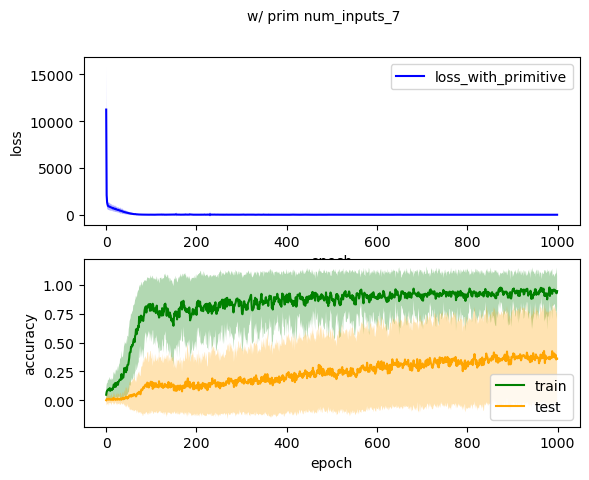

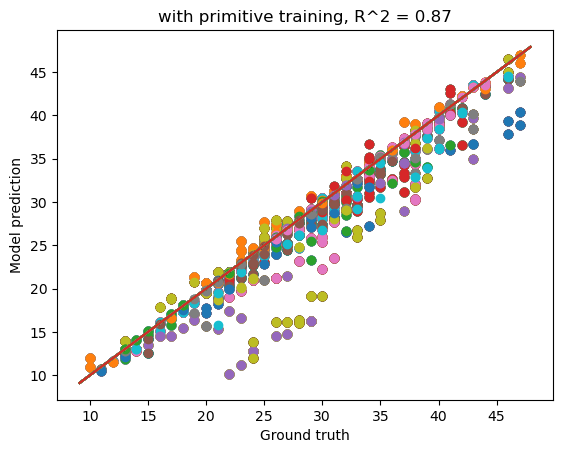

In [33]:
## same model

t1 = time.time()
res2  = Parallel(n_jobs = -1)(delayed(run_exp1_same_mod)(model_init, trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res2])
acc_train = np.array([r['acc'][:,0] for r in res2]).T
acc_test = np.array([r['acc'][:,1] for r in res2]).T
mods = [r['mod'] for r in res2]
tests = [r['test'] for r in res2]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

time:  10.850166364510853


,label,pred,acc
trial,,,
"['B', '+', 'A', '+', 'C']",22.0,20.653676,0.156250
"['D', '+', 'A', '+', 'B']",21.0,18.644015,0.062500
"['C', '+', 'A', '+', 'C']",26.0,23.288680,0.046875
"['D', '+', 'A', '+', 'E']",29.0,26.533235,0.046875
"['E', '+', 'A', '+', 'B']",26.0,22.613289,0.031250
"['E', '+', 'A', '+', 'E']",34.0,30.508834,0.031250
"['B', '+', 'C', '+', 'A']",22.0,17.450153,0.000000
"['C', '+', 'C', '+', 'A']",26.0,21.452428,0.000000


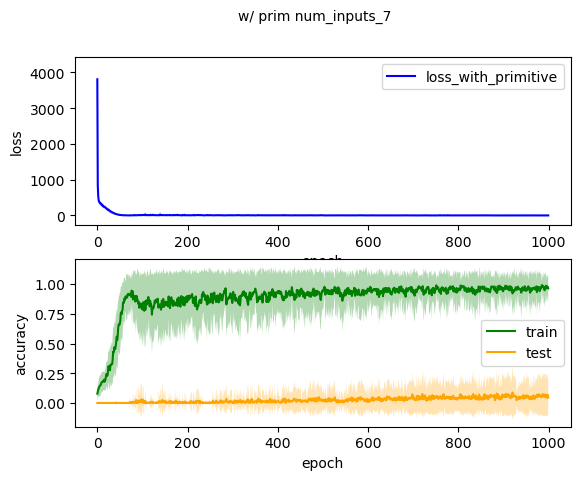

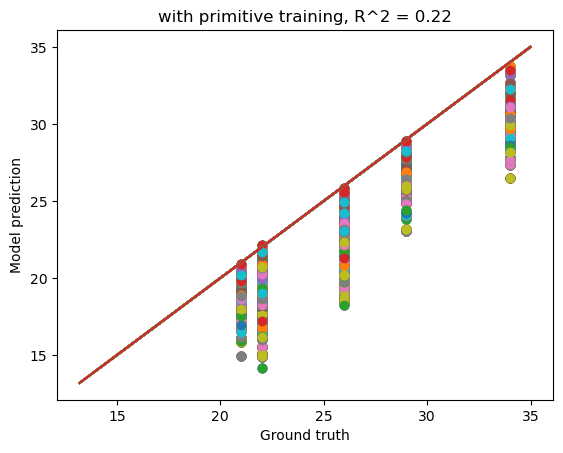

In [34]:
# same dict
t1 = time.time()
res3  = Parallel(n_jobs = -1)(delayed(run_exp1_same_dict)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res3])
acc_train = np.array([r['acc'][:,0] for r in res3]).T
acc_test = np.array([r['acc'][:,1] for r in res3]).T
mods = [r['mod'] for r in res3]
tests = [r['test'] for r in res3]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

In [36]:
# New dict

num_inputs = 5

total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {'X':0}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]

# new model
model_init = OneStepRNN(input_size, output_size, hidden_size, num_layers)


time:  15.040327048301696


,label,pred,acc
trial,,,
"['B', '+', 'A', '+', 'C']",22.0,20.736024,0.265625
"['D', '+', 'A', '+', 'B']",21.0,18.642404,0.140625
"['D', '+', 'A', '+', 'E']",29.0,26.459870,0.140625
"['C', '+', 'A', '+', 'C']",26.0,23.244961,0.125000
"['E', '+', 'A', '+', 'B']",26.0,22.574576,0.109375
"['E', '+', 'A', '+', 'E']",34.0,30.409600,0.093750
"['B', '+', 'C', '+', 'A']",22.0,17.661550,0.000000
"['C', '+', 'C', '+', 'A']",26.0,21.665284,0.000000


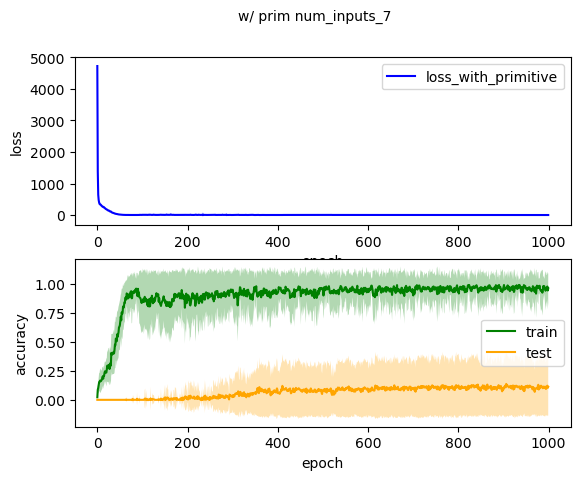

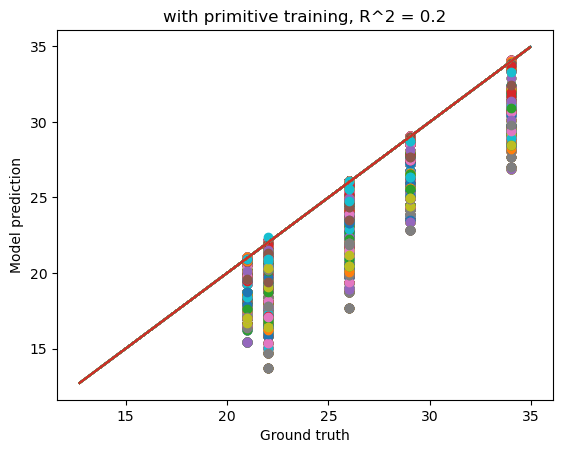

In [37]:
## same both
model_init = OneStepRNN(input_size, output_size, hidden_size, num_layers)
t1 = time.time()
res4  = Parallel(n_jobs = -1)(delayed(run_exp1_same_both)(model_init, trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res4])
acc_train = np.array([r['acc'][:,0] for r in res4]).T
acc_test = np.array([r['acc'][:,1] for r in res4]).T
mods = [r['mod'] for r in res4]
tests = [r['test'] for r in res4]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

time:  19.535229750474294


,label,pred,acc
trial,,,
"['B', '+', 'A', '+', 'C']",22.0,20.710103,0.250000
"['D', '+', 'A', '+', 'E']",29.0,26.588787,0.125000
"['C', '+', 'A', '+', 'C']",26.0,23.335116,0.109375
"['D', '+', 'A', '+', 'B']",21.0,18.700741,0.109375
"['E', '+', 'A', '+', 'B']",26.0,22.631827,0.062500
"['E', '+', 'A', '+', 'E']",34.0,30.533433,0.046875
"['B', '+', 'C', '+', 'A']",22.0,17.408738,0.000000
"['C', '+', 'C', '+', 'A']",26.0,21.429861,0.000000


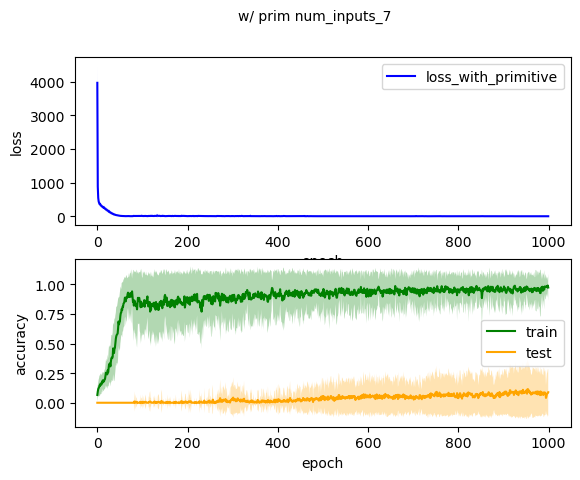

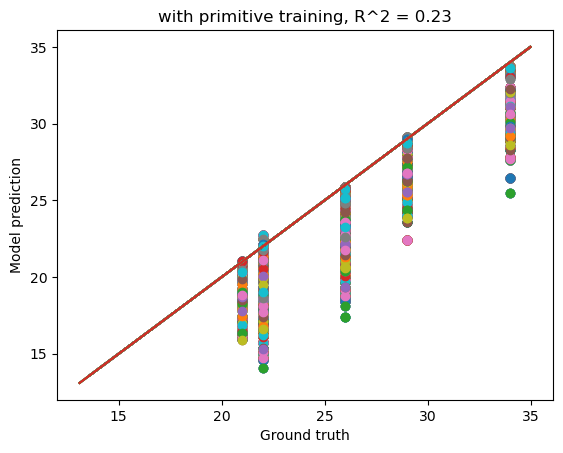

In [38]:
# same dict
t1 = time.time()
res5  = Parallel(n_jobs = -1)(delayed(run_exp1_same_dict)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res5])
acc_train = np.array([r['acc'][:,0] for r in res5]).T
acc_test = np.array([r['acc'][:,1] for r in res5]).T
mods = [r['mod'] for r in res5]
tests = [r['test'] for r in res5]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

time:  18.561473015944163


,label,pred,acc
trial,,,
"['D', '+', 'A', '+', 'B']",29.343750,28.639494,0.578125
"['D', '+', 'A', '+', 'E']",28.296875,27.738695,0.578125
"['B', '+', 'A', '+', 'C']",30.218750,29.566979,0.546875
"['C', '+', 'A', '+', 'C']",28.890625,28.225407,0.515625
"['E', '+', 'A', '+', 'B']",30.500000,29.607871,0.500000
"['E', '+', 'A', '+', 'E']",29.453125,28.721742,0.484375
"['B', '+', 'C', '+', 'A']",30.218750,29.098227,0.359375
"['C', '+', 'C', '+', 'A']",28.890625,27.800813,0.359375


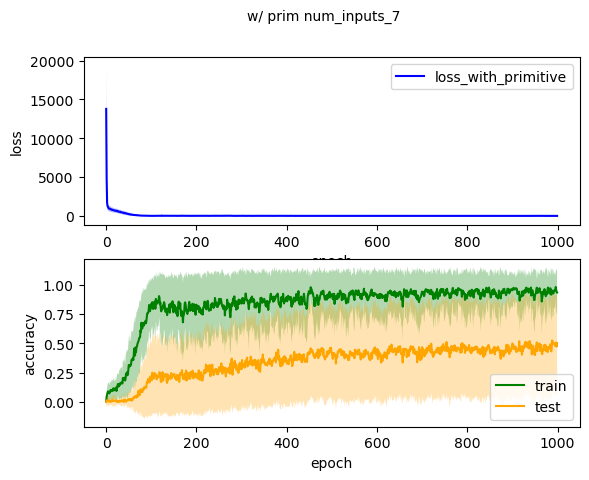

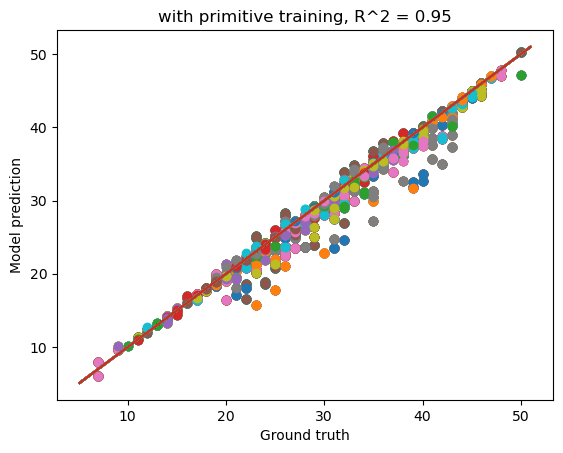

In [39]:
## same model

t1 = time.time()
res6  = Parallel(n_jobs = -1)(delayed(run_exp1_same_mod)(model_init, trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res6])
acc_train = np.array([r['acc'][:,0] for r in res6]).T
acc_test = np.array([r['acc'][:,1] for r in res6]).T
mods = [r['mod'] for r in res6]
tests = [r['test'] for r in res6]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

In [40]:
# change both

time:  10.315790549914043


,label,pred,acc
trial,,,
"['C', '+', 'A', '+', 'C']",30.281250,29.702363,0.578125
"['B', '+', 'A', '+', 'C']",29.703125,29.138432,0.546875
"['D', '+', 'A', '+', 'B']",29.078125,28.568129,0.531250
"['D', '+', 'A', '+', 'E']",28.703125,28.220293,0.531250
"['E', '+', 'A', '+', 'B']",28.750000,28.250493,0.500000
"['E', '+', 'A', '+', 'E']",28.375000,27.926006,0.500000
"['B', '+', 'C', '+', 'A']",29.703125,28.691462,0.390625
"['C', '+', 'C', '+', 'A']",30.281250,29.266172,0.375000


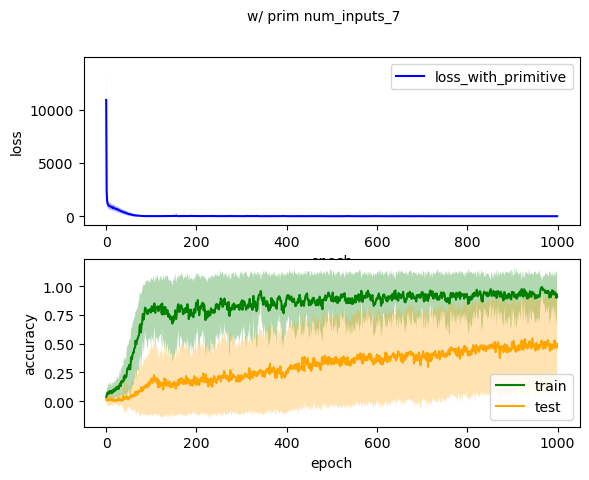

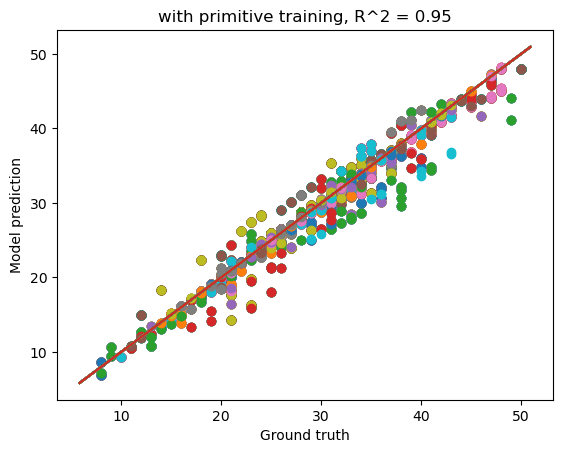

In [49]:
t1 = time.time()
res7  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res7])
acc_train = np.array([r['acc'][:,0] for r in res7]).T
acc_test = np.array([r['acc'][:,1] for r in res7]).T
mods = [r['mod'] for r in res7]
tests = [r['test'] for r in res7]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

time:  68.58786374727885


,label,pred,acc
trial,,,
"['D', '+', 'A', '+', 'E']",30.250000,28.872110,0.406250
"['B', '+', 'A', '+', 'C']",29.421875,28.125007,0.375000
"['D', '+', 'A', '+', 'B']",29.343750,28.076385,0.375000
"['C', '+', 'A', '+', 'C']",29.937500,28.615230,0.359375
"['E', '+', 'A', '+', 'B']",29.812500,28.560285,0.343750
"['E', '+', 'A', '+', 'E']",30.718750,29.349123,0.343750
"['B', '+', 'C', '+', 'A']",29.421875,27.802781,0.265625
"['C', '+', 'C', '+', 'A']",29.937500,28.295140,0.265625


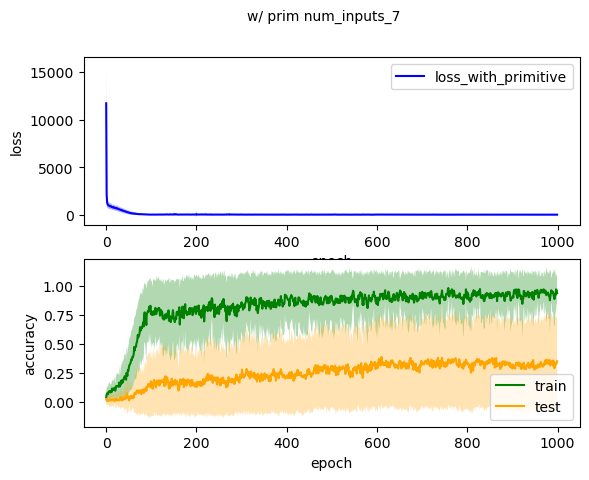

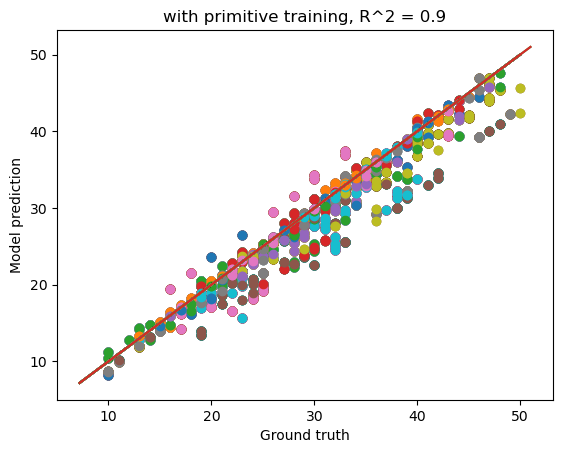

In [50]:
t1 = time.time()
res8  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res8])
acc_train = np.array([r['acc'][:,0] for r in res8]).T
acc_test = np.array([r['acc'][:,1] for r in res8]).T
mods = [r['mod'] for r in res8]
tests = [r['test'] for r in res8]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

In [ ]:
## work out. variance of response - with correct initialisation

In [55]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 1)


time:  17.35165807008743


,label,pred,acc
trial,,,
"['E', '+', 'A', '+', 'B']",28.000000,26.695901,0.421875
"['D', '+', 'A', '+', 'B']",29.140625,28.040451,0.375000
"['D', '+', 'A', '+', 'E']",29.171875,28.101098,0.359375
"['B', '+', 'C', '+', 'A']",28.562500,27.103279,0.343750
"['C', '+', 'A', '+', 'C']",29.156250,28.064534,0.343750
"['E', '+', 'A', '+', 'E']",28.031250,26.856463,0.328125
"['B', '+', 'A', '+', 'C']",28.562500,27.276364,0.312500
"['C', '+', 'C', '+', 'A']",29.156250,27.710129,0.312500


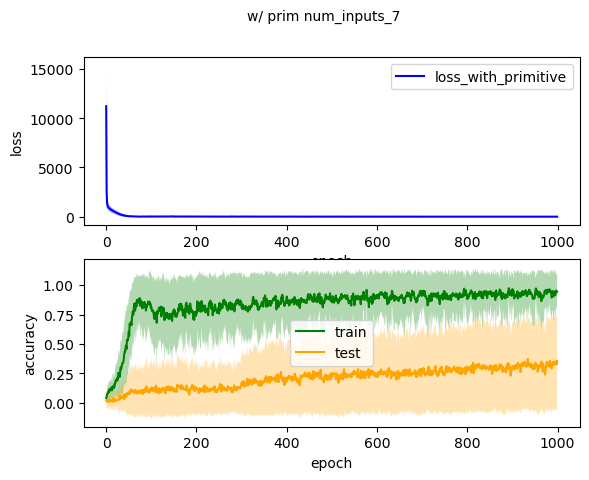

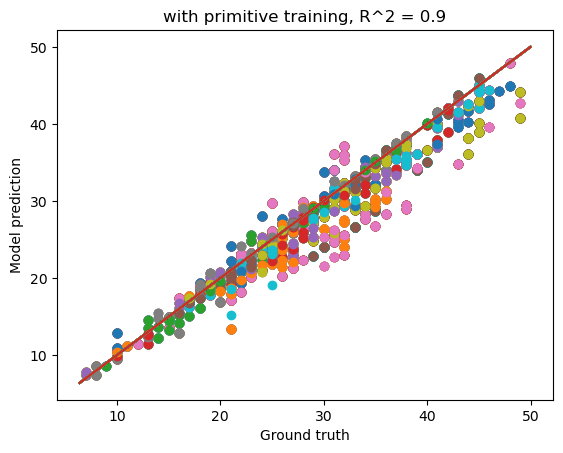

In [56]:
t1 = time.time()
res9  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res9])
acc_train = np.array([r['acc'][:,0] for r in res9]).T
acc_test = np.array([r['acc'][:,1] for r in res9]).T
mods = [r['mod'] for r in res9]
tests = [r['test'] for r in res9]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

In [60]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')


time:  127.72674878438313


,label,pred,acc
trial,,,
"['C', '+', 'A', '+', 'C']",29.812500,27.995355,0.296875
"['D', '+', 'A', '+', 'B']",28.968750,27.179615,0.250000
"['D', '+', 'A', '+', 'E']",28.703125,26.959308,0.250000
"['B', '+', 'A', '+', 'C']",29.468750,27.521312,0.234375
"['E', '+', 'A', '+', 'E']",28.593750,26.893877,0.218750
"['E', '+', 'A', '+', 'B']",28.859375,27.091437,0.203125
"['B', '+', 'C', '+', 'A']",29.468750,27.084238,0.140625
"['C', '+', 'C', '+', 'A']",29.812500,27.429349,0.125000


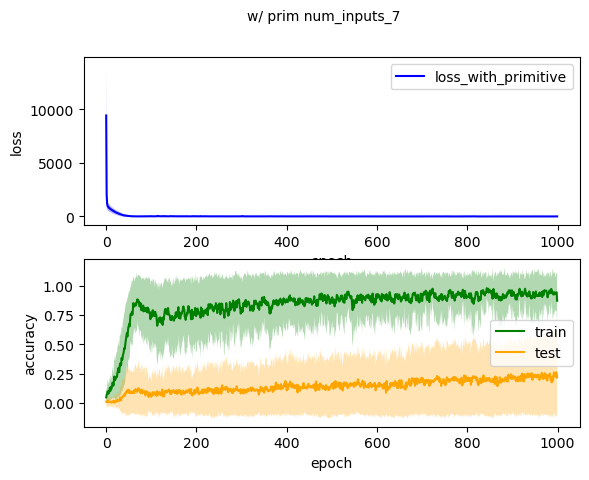

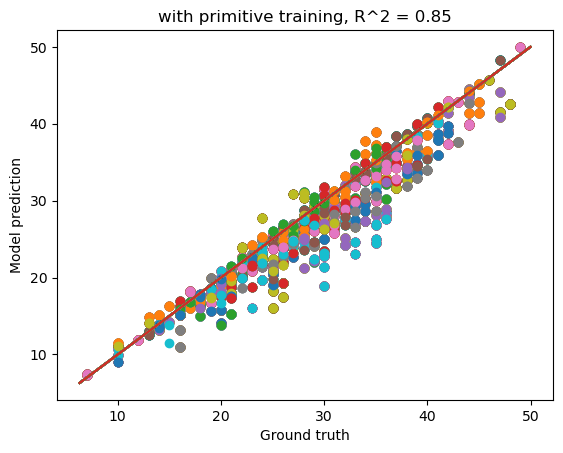

In [61]:
t1 = time.time()
res9  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res9])
acc_train = np.array([r['acc'][:,0] for r in res9]).T
acc_test = np.array([r['acc'][:,1] for r in res9]).T
mods = [r['mod'] for r in res9]
tests = [r['test'] for r in res9]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)